Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [6]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [8]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [9]:
id = test[['id']]

In [10]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # # replace nans in ward with mean of that ward
    for feature in cols_with_zeros:
        mean_replace = X.groupby('ward')[feature].transform('mean')
        X[feature] = X[feature].fillna(mean_replace)
    
    # # replace nan in region with mean of that region
    for feature in cols_with_zeros:
        mean_replace = X.groupby('region_code')[feature].transform('mean')
        X[feature] = X[feature].fillna(mean_replace)
    
    # amount of water per person
    X['water_per_person'] = X['amount_tsh']/X['population']

    drop_cols = ['quantity_group', 'payment_type','recorded_by','id','num_private','amount_tsh', 'wpt_name','subvillage','management_group']
    # Drop from train and test data set
    X = X.drop(columns=drop_cols)

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [11]:

# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 3000].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# making metrix and vectors x,y
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [12]:
# replacing OneHotEncoder with 'ordinal'
pipeline = make_pipeline(
     ce.OrdinalEncoder(),
     SimpleImputer(strategy='median'),
     RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=300,
                            min_samples_leaf=3,max_depth=25)
)

# fit pipeline
pipeline.fit(X_train, y_train)

# score with validation data
print('Validation Accuracy:',pipeline.score(X_train, y_train))
print('Validation Accuracy:',pipeline.score(X_val, y_val))

Validation Accuracy: 0.8999579124579125
Validation Accuracy: 0.8134680134680135


In [ ]:
pipeline = make_pipeline(
     ce.OrdinalEncoder(),
     SimpleImputer(),
     RandomForestClassifier(random_state=42)
)

p_distributions = {
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__n_estimators':range(200,400),
    'randomforestclassifier__min_samples_leaf':range(1,6),
    'randomforestclassifier__min_samples_split':range(1,15),
    'randomforestclassifier__max_depth':range(1,50)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=p_distributions,
    n_iter = 50,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

In [ ]:
# search.best_params_

# {'randomforestclassifier__max_depth': 25,
#  'randomforestclassifier__min_samples_leaf': 2,
#  'randomforestclassifier__min_samples_split': 3,
#  'randomforestclassifier__n_estimators': 330,
#  'simpleimputer__strategy': 'median'}

In [ ]:
# search.best_score_

In [ ]:
# pipeline = search.best_estimator_

# y_pred = pipeline.predict(X_val)

# accuracy_score(y_val, y_pred)

In [ ]:
# pipeline = search.best_estimator_

# y_pred = pipeline.predict(X_train)

# accuracy_score(y_train, y_pred)

In [14]:
# replacing OneHotEncoder with 'ordinal'
pipeline = make_pipeline(
     ce.OrdinalEncoder(),
     SimpleImputer(strategy='median'),
     RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=330,
                            min_samples_leaf=2,max_depth=25,min_samples_split=3)
)

# {'randomforestclassifier__max_depth': 25,
#  'randomforestclassifier__min_samples_leaf': 2,
#  'randomforestclassifier__min_samples_split': 3,
#  'randomforestclassifier__n_estimators': 330,
#  'simpleimputer__strategy': 'median'}

# fit pipeline
pipeline.fit(X_train, y_train)

# score with validation data
print('Validation Accuracy:',pipeline.score(X_train, y_train))
print('Validation Accuracy:',pipeline.score(X_val, y_val))

Validation Accuracy: 0.9272516835016835
Validation Accuracy: 0.8174242424242424


In [15]:
from sklearn.metrics import plot_confusion_matrix

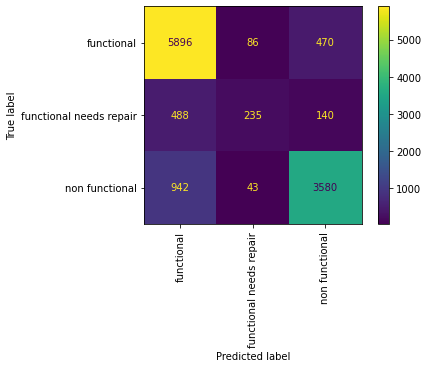

In [16]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f',
                      xticks_rotation='vertical')

In [19]:
y_pred = pipeline.predict(X_val)

In [17]:
from sklearn.metrics import classification_report

In [21]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.86      6452
functional needs repair       0.65      0.27      0.38       863
         non functional       0.85      0.78      0.82      4565

               accuracy                           0.82     11880
              macro avg       0.77      0.66      0.69     11880
           weighted avg       0.81      0.82      0.81     11880



In [22]:
# we want to get the water pumps that we know need repair

y_train = y_train != 'functional'
y_val = y_val != 'functional'

y_train.value_counts(normalize=True)

False    0.543077
True     0.456923
Name: status_group, dtype: float64

In [23]:
len(val) == len(test)

False

In [24]:
pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'basin', 'region',
                                      'lga', 'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'payment', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'w...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=25, max_features='auto',
                                

In [25]:
y_pred = pipeline.predict(X_val)

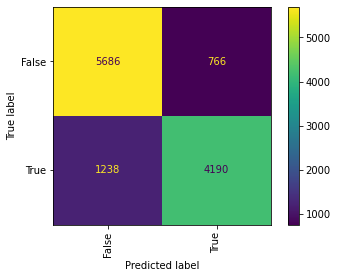

In [26]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [28]:
import seaborn as sns

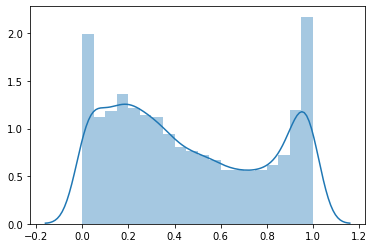

In [29]:
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
sns.distplot(y_pred_proba)

False    9882
True     1998
dtype: int64

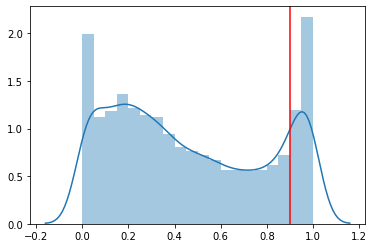

In [32]:
threshold = .90

y_pred = y_pred_proba > threshold

ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [33]:
results = pd.DataFrame({'y_val':y_val, 'y_pred_proba':y_pred_proba})
results

,y_val,y_pred_proba
3290,False,0.571471
47666,False,0.451465
2538,False,0.281051
53117,True,0.294703
51817,True,0.900811
...,...,...
9006,True,0.505553
20942,True,0.996910
29031,True,0.568589
3493,True,0.314494


In [34]:
top2000 = results.sort_values(by='y_pred_proba', ascending=False)[:2000]

In [36]:
top2000.sample(n=10)

,y_val,y_pred_proba
678,True,0.965181
20521,True,0.973182
5568,True,0.915608
42000,True,0.923964
53405,True,0.986162
2097,True,0.979503
12823,True,0.987218
40430,True,0.958014
41623,True,0.901881
37857,True,0.913629


In [41]:
trips = 2000

relevant_recommendations = top2000['y_val'].sum()

In [42]:
relevant_recommendations

1968

In [46]:
prescision_at_k_2000 = relevant_recommendations / trips

prescision_at_k_2000

0.984

In [47]:
from sklearn.metrics import roc_curve

In [58]:
fpr,tpr, threshold = roc_curve(y_val, y_pred_proba)


prescision = pd.DataFrame({'False Positive Rate':fpr,
              'True Positive Rate':tpr,
              'Threshold':threshold})

prescision

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.013449,1.000000
2,0.000000,0.016396,0.999966
3,0.000000,0.016949,0.999856
4,0.000000,0.017318,0.999811
...,...,...,...
3205,0.996435,1.000000,0.000125
3206,0.996900,1.000000,0.000092
3207,0.998295,1.000000,0.000063
3208,0.999380,1.000000,0.000046


In [61]:
import matplotlib.pyplot as plt

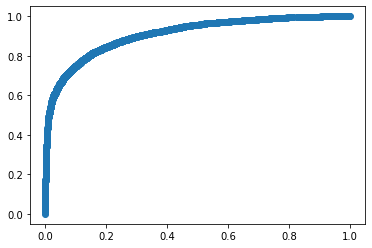

In [62]:
plt.scatter(fpr,tpr)

In [63]:
from sklearn.metrics import roc_auc_score

In [64]:
roc_auc_score(y_val, y_pred_proba)

0.909209043164853